<a href="https://colab.research.google.com/github/kofiadom/Langgraph-Intro/blob/main/Langraph_Agents_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tutorial: Developing a Simple Agent with LangGraph and Llama3.3 in Groq**



In this tutorial, I will walk through the process of developing a simple agent using LangGraph and the Llama3 model in Groq. This agent will be capable of fetching weather information and generating a conversational weather report. We will cover key concepts such as states, nodes, edges, and routing.

##**Key Concepts**

1. **State**:
A state represents the current context or data that the agent is working with. In our case, we use MessagesState to hold the messages exchanged between the user and the agent.
Usage: The state is passed around as the agent processes user inputs and generates responses.


2. **Node**:
A node is a functional unit in the graph that performs a specific task. Each node can represent a function or a tool that the agent can invoke.
Example: In our code, we define nodes such as llm_with_tools and generate_weather_report to handle different parts of the conversation and weather reporting.


3. **Edges**:
Edges connect nodes in the graph, defining the flow of execution from one node to another. There are 2 types. First, **Standard edges** which connect nodes in a linear fashion. Second, **Conditional edges** which allow for branching logic based on certain conditions. For example, if the last message from the assistant is a tool call, the flow will route to the tools node; otherwise, it will end the process.



4. **Routing**:
Routing determines how the agent transitions between different nodes based on the current state and conditions. **Implementation**: In our code, we use add_conditional_edges to define how the agent should respond based on the type of message received.

## **Step 1: Import Required Libraries**

In [1]:
!pip install -q typing_extensions langgraph langchain_openai langchain-groq langchain_core python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:00


In [2]:
import requests
import os
from IPython.display import Image, display
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
import json
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## **Step 2: Define Functions**

In [3]:
from google.colab import userdata
weather_api_key = userdata.get('WEATHER_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

def get_detailed_weather_weatherapi(city: str) -> str:
    """
    Fetches an extended weather report, including air quality, for a given city using WeatherAPI.

    Parameters:
        city (str): The name of the city to get the weather for.
        api_key (str): Your WeatherAPI key.

    Returns:
        str: A detailed weather and air quality report as a text message.
    """
    base_url = "http://api.weatherapi.com/v1/current.json"
    params = {
        "key": weather_api_key,
        "q": city,
        "aqi": "yes"  # Include air quality data
    }

    try:
        response = requests.get(base_url, params=params)
        data = response.json()

        if response.status_code == 200:
            # Extract key weather details
            location = data["location"]["name"]
            country = data["location"]["country"]
            temperature = data["current"]["temp_c"]
            feels_like = data["current"]["feelslike_c"]
            condition = data["current"]["condition"]["text"]
            wind_speed = data["current"]["wind_kph"]
            wind_direction = data["current"]["wind_dir"]
            humidity = data["current"]["humidity"]
            cloudiness = data["current"]["cloud"]
            last_updated = data["current"]["last_updated"]

            # Extract air quality data
            aqi_data = data["current"]["air_quality"]
            co = aqi_data.get("co", "N/A")  # Carbon Monoxide
            no2 = aqi_data.get("no2", "N/A")  # Nitrogen Dioxide
            o3 = aqi_data.get("o3", "N/A")  # Ozone
            pm10 = aqi_data.get("pm10", "N/A")  # Particulate Matter 10
            pm2_5 = aqi_data.get("pm2_5", "N/A")  # Particulate Matter 2.5
            so2 = aqi_data.get("so2", "N/A")  # Sulfur Dioxide

            # Build the detailed weather and air quality report
            weather_report = (
                f"Weather in {location}, {country}:\n"
                f"- Condition: {condition}\n"
                f"- Temperature: {temperature}°C (Feels like: {feels_like}°C)\n"
                f"- Wind: {wind_speed} kph, Direction: {wind_direction}\n"
                f"- Humidity: {humidity}%\n"
                f"- Cloudiness: {cloudiness}%\n"
                f"- Last updated: {last_updated}\n\n"
                f"Air Quality Index (AQI):\n"
                f"- CO (Carbon Monoxide): {co} µg/m³\n"
                f"- NO2 (Nitrogen Dioxide): {no2} µg/m³\n"
                f"- O3 (Ozone): {o3} µg/m³\n"
                f"- PM10 (Particulate Matter <10µm): {pm10} µg/m³\n"
                f"- PM2.5 (Particulate Matter <2.5µm): {pm2_5} µg/m³\n"
                f"- SO2 (Sulfur Dioxide): {so2} µg/m³"
            )
            return weather_report
        else:
            return f"Error: {data.get('error', {}).get('message', 'Unable to fetch weather data')}"
    except Exception as e:
        return f"An error occurred: {str(e)}"

city_name = "Kumasi"
print(get_detailed_weather_weatherapi(city_name))

Weather in Kumasi, Ghana:
- Condition: Partly cloudy
- Temperature: 35.2°C (Feels like: 33.6°C)
- Wind: 4.7 kph, Direction: ESE
- Humidity: 44%
- Cloudiness: 50%
- Last updated: 2025-01-23 14:30

Air Quality Index (AQI):
- CO (Carbon Monoxide): 595.7 µg/m³
- NO2 (Nitrogen Dioxide): 1.48 µg/m³
- O3 (Ozone): 120.0 µg/m³
- PM10 (Particulate Matter <10µm): 169.645 µg/m³
- PM2.5 (Particulate Matter <2.5µm): 57.35 µg/m³
- SO2 (Sulfur Dioxide): 2.035 µg/m³


In [4]:
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY)
llm_tools = llm.bind_tools([get_detailed_weather_weatherapi])

tool_call = llm_tools.invoke([HumanMessage(content="How is the weather in Berlin?")])

print(json.dumps(vars(tool_call), indent=4))

{
    "content": "",
    "additional_kwargs": {
        "tool_calls": [
            {
                "id": "call_b4aa",
                "function": {
                    "arguments": "{\"city\": \"Berlin\", \"api_key\": \"YOUR_API_KEY_HERE\"}",
                    "name": "get_detailed_weather_weatherapi"
                },
                "type": "function"
            }
        ]
    },
    "response_metadata": {
        "token_usage": {
            "completion_tokens": 28,
            "prompt_tokens": 311,
            "total_tokens": 339,
            "completion_time": 0.101818182,
            "prompt_time": 0.067259609,
            "queue_time": 0.11956694500000001,
            "total_time": 0.169077791
        },
        "model_name": "llama-3.3-70b-versatile",
        "system_fingerprint": "fp_1ae2705acb",
        "finish_reason": "tool_calls",
        "logprobs": null
    },
    "type": "ai",
    "name": null,
    "id": "run-07b6d138-b7a9-4fce-96ce-7dc983dd5799-0",
    "example

In [5]:
# Nodes
def llm_with_tools(state: MessagesState):
    return {"messages": [llm_tools.invoke(state["messages"])]}

def generate_weather_report(state: MessagesState):
    # Extract the weather table from the last message
    weather_table = state["messages"][-1].content

    prompt = f"""
    You are a friendly and chatty weather reporter who shares the weather as if you’re experiencing it yourself in the location.
    Your goal is to describe the weather in a way that feels personal, engaging, and easy to understand.
    Use the provided data to create a conversational response that includes feelings and suggests possible activities based on the weather.

    Here is the weather data:
    {weather_table}

    Use the data above to create a response. Here's the tone you're aiming for:
    1. Friendly and casual, like you're talking to a friend.
    2. Include your personal perspective, as if you’re sitting in this weather right now.
    3. Suggest one or two activities based on the weather.
    4. Make your answer short: just one or two sentences.
    """

    state["messages"].append(HumanMessage(content=prompt))
    return {"messages": [llm_tools.invoke(state["messages"])]}

## **Step 3: Build the Graph State**

**StateGraph**: We create a state graph to manage the flow of messages.  
**Adding Nodes**: We add nodes for invoking the LLM, fetching weather data, and generating reports.  
**Adding Edges**: We define the flow of execution, including conditional edges that determine the next step based on the last message.

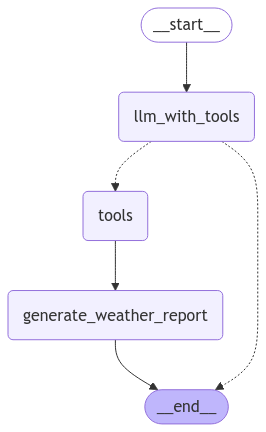

In [6]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tools", llm_with_tools)
builder.add_node("tools", ToolNode([get_detailed_weather_weatherapi]))
builder.add_node("generate_weather_report", generate_weather_report)

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges(
    "llm_with_tools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "generate_weather_report")
builder.add_edge("generate_weather_report", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## **Step4: Invoke the Graph**

In [7]:
messages = [HumanMessage(content="How is the weather in Kumasi today?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

How is the weather in Kumasi today?
================================== Ai Message ==================================
Tool Calls:
  get_detailed_weather_weatherapi (call_ykg1)
 Call ID: call_ykg1
  Args:
    city: Kumasi
    api_key: YOUR_API_KEY_HERE
================================= Tool Message =================================
Name: get_detailed_weather_weatherapi

Weather in Kumasi, Ghana:
- Condition: Partly cloudy
- Temperature: 35.2°C (Feels like: 33.6°C)
- Wind: 4.7 kph, Direction: ESE
- Humidity: 44%
- Cloudiness: 50%
- Last updated: 2025-01-23 14:30

Air Quality Index (AQI):
- CO (Carbon Monoxide): 595.7 µg/m³
- NO2 (Nitrogen Dioxide): 1.48 µg/m³
- O3 (Ozone): 120.0 µg/m³
- PM10 (Particulate Matter <10µm): 169.645 µg/m³
- PM2.5 (Particulate Matter <2.5µm): 57.35 µg/m³
- SO2 (Sulfur Dioxide): 2.035 µg/m³
================================ Human Message =================================


    You ar